In [454]:
words = open('names.txt', 'r').read().splitlines()

In [328]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [329]:
len(words)

32033

In [330]:
min(len(w) for w in words)

2

In [331]:
max(len(w) for w in words)

15

In [332]:
# Bigram language model
# Looking at tuples of characters

In [333]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [334]:
_s = sorted(b.items(), key = lambda kv: -kv[1])

In [335]:
import torch


In [346]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [347]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [352]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

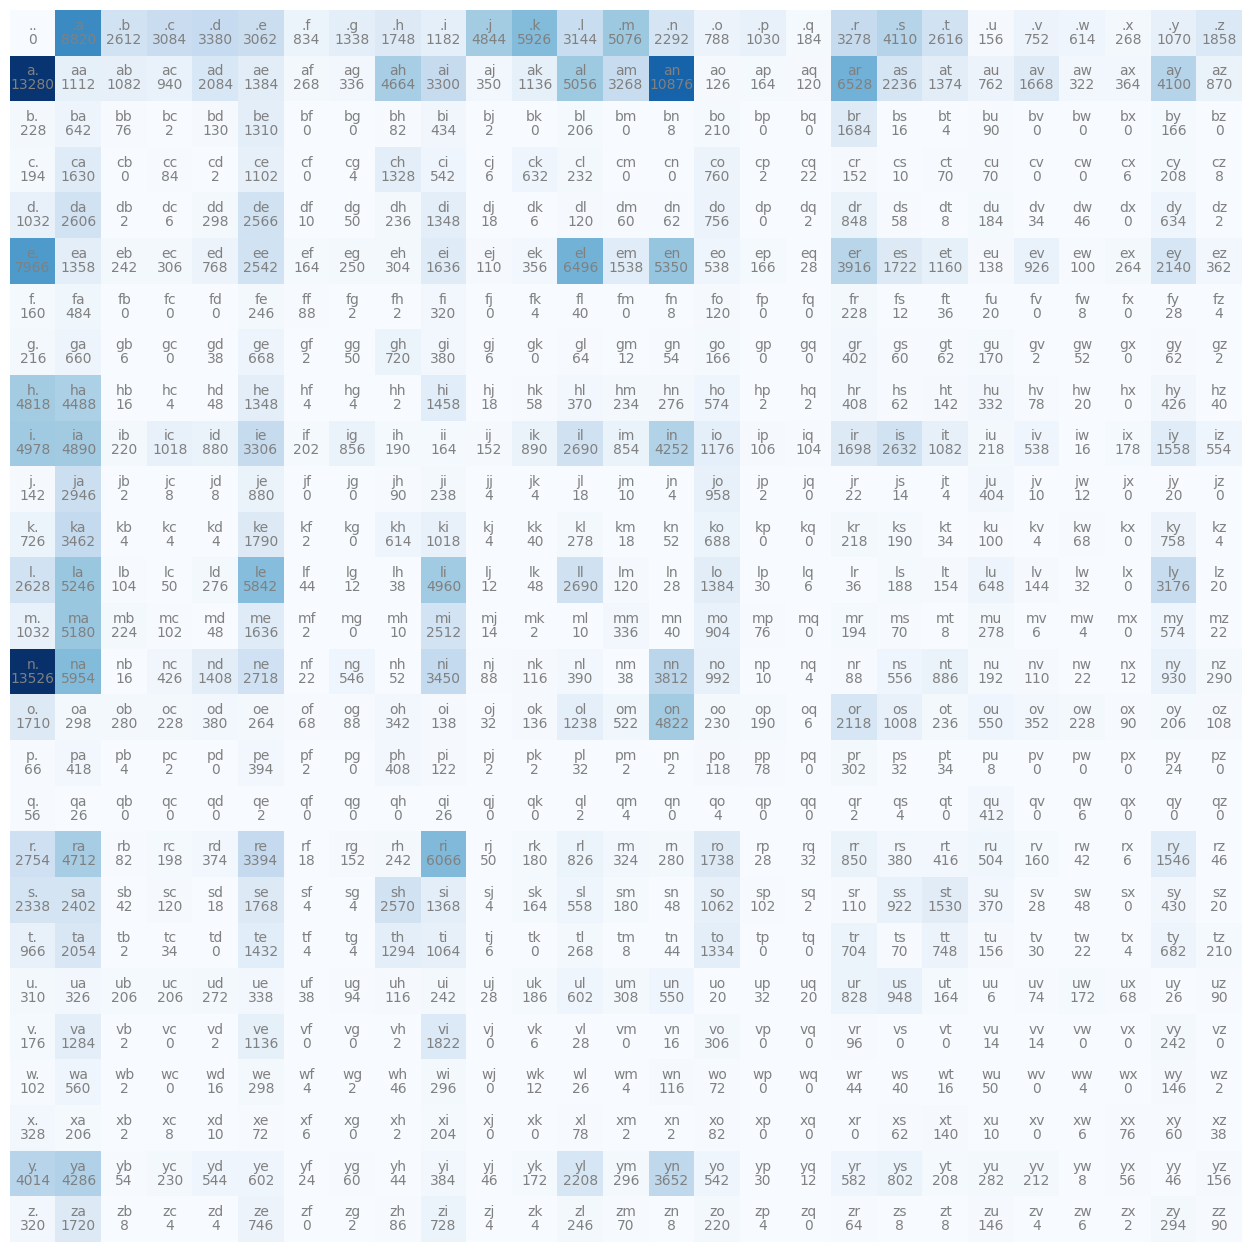

In [461]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [399]:
N[0]

tensor([   0, 8820, 2612, 3084, 3380, 3062,  834, 1338, 1748, 1182, 4844, 5926,
        3144, 5076, 2292,  788, 1030,  184, 3278, 4110, 2616,  156,  752,  614,
         268, 1070, 1858], dtype=torch.int32)

In [400]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [401]:
# https://pytorch.org/docs/stable/generated/torch.multinomial.html
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'j'

In [403]:
p.shape

torch.Size([3])

In [404]:
P.shape

torch.Size([27, 27])

In [402]:

g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p / p.sum()
p


tensor([0.6064, 0.3033, 0.0903])

In [462]:
P = (N+1).float()
P = P / P.sum(1, keepdim=True)

# Broadcasting semantics https://pytorch.org/docs/stable/notes/broadcasting.html
# 27, 27
# 27, 1
# ~43:00 - divide array by array
# In broadcasting you align on the right, and go from right to left
# That is why we need keepdim=True, otherwise its 27,27/1,27
# TODO: Read broadcasting.html and keepdim

In [467]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        # p = N[ix].float()
        # p = p / p.sum()
        # p = torch.ones(27)/27.0
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            break
    
        out.append(itos[ix])
    
    print(''.join(out))

junide
janasah
p
cony
a


In [482]:
# Evaluate quality of the bigram model
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood <- used in practice

# log(a*b*c) = log(a) + log(b) + log(c)

log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]

        logprob = torch.log(prob)
        log_likelihood+=logprob
        n+=1
        # print(f'{ch1}{ch2}: {logprob:.4f}')

nll = -log_likelihood
nll/n # normalized log likelihood

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')
print('------')
# loss function -> the lower the better -> nll starts at 0 (best) and grows with loss


log_likelihood=tensor(-559938.8125)
nll=tensor(559938.8125)
2.4543004035949707
------


In [509]:
# create the training set of all the bigrams
xs, ys = [], []
for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

# tensor vs Tensor
# torch.tensor infers the dtype while Tensor defaults to floaties

In [510]:
F = torch.nn.functional

xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [511]:
xenc.shape

torch.Size([5, 27])

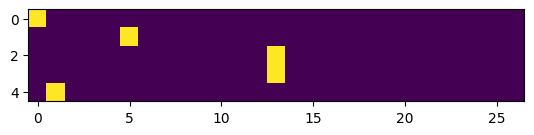

In [516]:
plt.imshow(xenc)

In [577]:
# construct first neuron
# weights
# xenc @ W -> @ is matrix multiplication in pytorch
# (5,27) @ (27, 27) -> (5, 27)
W = torch.randn(27, 27)
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
probs
# output is probability distributions


tensor([[0.0245, 0.1233, 0.0256, 0.0770, 0.0417, 0.0686, 0.0180, 0.0182, 0.0288,
         0.0835, 0.0071, 0.0291, 0.0290, 0.0115, 0.0232, 0.0960, 0.0207, 0.0060,
         0.0994, 0.0351, 0.0127, 0.0046, 0.0641, 0.0194, 0.0102, 0.0093, 0.0134],
        [0.0598, 0.0223, 0.0012, 0.0189, 0.1238, 0.0290, 0.0177, 0.0163, 0.0277,
         0.0257, 0.0438, 0.0199, 0.0146, 0.1524, 0.0207, 0.0176, 0.0095, 0.1610,
         0.0415, 0.0102, 0.0168, 0.0140, 0.0061, 0.0533, 0.0178, 0.0495, 0.0090],
        [0.0093, 0.0705, 0.0152, 0.0229, 0.0110, 0.0655, 0.0080, 0.0406, 0.0088,
         0.0078, 0.0103, 0.0165, 0.3578, 0.0078, 0.0124, 0.0086, 0.0249, 0.0071,
         0.0389, 0.0527, 0.0133, 0.0483, 0.0228, 0.0453, 0.0146, 0.0093, 0.0498],
        [0.0093, 0.0705, 0.0152, 0.0229, 0.0110, 0.0655, 0.0080, 0.0406, 0.0088,
         0.0078, 0.0103, 0.0165, 0.3578, 0.0078, 0.0124, 0.0086, 0.0249, 0.0071,
         0.0389, 0.0527, 0.0133, 0.0483, 0.0228, 0.0453, 0.0146, 0.0093, 0.0498],
        [0.0184, 0.0138,

In [549]:
# 1:20:00

In [584]:
probs[0]

tensor([0.0245, 0.1233, 0.0256, 0.0770, 0.0417, 0.0686, 0.0180, 0.0182, 0.0288,
        0.0835, 0.0071, 0.0291, 0.0290, 0.0115, 0.0232, 0.0960, 0.0207, 0.0060,
        0.0994, 0.0351, 0.0127, 0.0046, 0.0641, 0.0194, 0.0102, 0.0093, 0.0134])

In [585]:
# Summary ->

In [587]:
xs

tensor([ 0,  5, 13, 13,  1])

In [588]:
ys

tensor([ 5, 13, 13,  1,  0])

In [630]:
# Randomly initialize 27 neuron weights, each neuron has 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(27, 27)

In [631]:
# Forward pass

xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W # predict log-counts
counts = logits.exp() # equiivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# last 2 lines are called 'softmax' h

In [632]:
nlls = torch.zeros(5)
for i in range(5):
    x = xs[i].item() #input char index
    y = xs[i].item() #label char index
    print('--------')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
    print('input to the neural net:', x)
    print('output probabilities from the neural net:', probs[i])
    print('label (actual next character):', y)
    p = probs[i, y]
    print('probability assigned by the net to the the correct character:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean())


--------
bigram example 1: .. (indexes 0,0)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0290, 0.0588, 0.0335, 0.0085, 0.0595, 0.0841, 0.0557, 0.0023, 0.0569,
        0.0234, 0.0994, 0.0577, 0.0230, 0.0118, 0.0664, 0.0104, 0.0065, 0.0417,
        0.0104, 0.0418, 0.0162, 0.0195, 0.0107, 0.0985, 0.0103, 0.0176, 0.0464])
label (actual next character): 0
probability assigned by the net to the the correct character: 0.028983592987060547
log likelihood: -3.541025400161743
negative log likelihood: 3.541025400161743
--------
bigram example 2: ee (indexes 5,5)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0143, 0.0271, 0.0605, 0.0110, 0.0178, 0.0512, 0.0443, 0.3165, 0.0213,
        0.0043, 0.0182, 0.0419, 0.0464, 0.0207, 0.0151, 0.0320, 0.0237, 0.0422,
        0.0075, 0.0402, 0.0017, 0.0092, 0.0793, 0.0139, 0.0070, 0.0229, 0.0100])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.0

In [633]:
# OPTIMIZATION ->

In [729]:
# create the training set of all the bigrams

xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# tensor vs Tensor
# torch.tensor infers the dtype while Tensor defaults to floaties

number of examples:  228146


In [752]:
# Randomly initialize 27 neuron weights, each neuron has 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)
# requires_grad=True: https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html

(W**2).mean()

tensor(0.9665, grad_fn=<MeanBackward0>)

In [812]:
# Gradient Descent

for k in range(10):
    # Forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
    print(loss.item())

    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()
    
    # update
    W.data += -50 * W.grad
    

2.4804189205169678
2.4804189205169678
2.4804186820983887
2.4804184436798096
2.4804182052612305
2.4804184436798096
2.4804182052612305
2.4804177284240723
2.480417490005493
2.480417490005493


In [819]:
for i in range(5):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W #predict log-counts
        counts = logits.exp() #normalize
        p = counts / counts.sum(1, keepdims=True)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            break
        out.append(itos[ix])

    
    print(''.join(out))

lttonoerol
balylosh
syaneezmayu
illigghaverigizan
cosalacmin
